# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [17]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 5e-9, 1e-8, 5e-8, 1e-7]
regularization_strengths = [5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6]

results = {}
best_val = -1
best_svm = None

svm = LinearSVM()
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=learning_rates[i], reg=regularization_strengths[j],
                    num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        results[(learning_rates[i],regularization_strengths[j])] = (acc_train,acc_val)
        if(best_val<(np.mean(y_val == y_val_pred), )): 
            best_val = acc_val
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 16.808589
iteration 100 / 1500: loss 16.825636
iteration 200 / 1500: loss 16.802333
iteration 300 / 1500: loss 16.794734
iteration 400 / 1500: loss 16.766595
iteration 500 / 1500: loss 16.757927
iteration 600 / 1500: loss 16.738890
iteration 700 / 1500: loss 16.712429
iteration 800 / 1500: loss 16.708136
iteration 900 / 1500: loss 16.687929
iteration 1000 / 1500: loss 16.685044
iteration 1100 / 1500: loss 16.678395
iteration 1200 / 1500: loss 16.645081
iteration 1300 / 1500: loss 16.635657
iteration 1400 / 1500: loss 16.618523
iteration 0 / 1500: loss 24.202821
iteration 100 / 1500: loss 24.150064
iteration 200 / 1500: loss 24.105482
iteration 300 / 1500: loss 24.034719
iteration 400 / 1500: loss 23.970470
iteration 500 / 1500: loss 23.907335
iteration 600 / 1500: loss 23.843054
iteration 700 / 1500: loss 23.785002
iteration 800 / 1500: loss 23.721519
iteration 900 / 1500: loss 23.662857
iteration 1000 / 1500: loss 23.609481
iteration 1100 / 1500: loss 23.54686

iteration 0 / 1500: loss 8.999093
iteration 100 / 1500: loss 8.999063
iteration 200 / 1500: loss 8.999134
iteration 300 / 1500: loss 8.999055
iteration 400 / 1500: loss 8.998965
iteration 500 / 1500: loss 8.998934
iteration 600 / 1500: loss 8.998871
iteration 700 / 1500: loss 8.998853
iteration 800 / 1500: loss 8.998868
iteration 900 / 1500: loss 8.998751
iteration 1000 / 1500: loss 8.998931
iteration 1100 / 1500: loss 8.998806
iteration 1200 / 1500: loss 8.998925
iteration 1300 / 1500: loss 8.998909
iteration 1400 / 1500: loss 8.998937
iteration 0 / 1500: loss 9.000202
iteration 100 / 1500: loss 9.000210
iteration 200 / 1500: loss 9.000100
iteration 300 / 1500: loss 9.000041
iteration 400 / 1500: loss 8.999836
iteration 500 / 1500: loss 8.999881
iteration 600 / 1500: loss 8.999894
iteration 700 / 1500: loss 8.999675
iteration 800 / 1500: loss 8.999721
iteration 900 / 1500: loss 8.999710
iteration 1000 / 1500: loss 8.999711
iteration 1100 / 1500: loss 8.999729
iteration 1200 / 1500: lo

iteration 300 / 1500: loss 8.999583
iteration 400 / 1500: loss 8.999761
iteration 500 / 1500: loss 8.999601
iteration 600 / 1500: loss 8.999727
iteration 700 / 1500: loss 8.999648
iteration 800 / 1500: loss 8.999654
iteration 900 / 1500: loss 8.999673
iteration 1000 / 1500: loss 8.999637
iteration 1100 / 1500: loss 8.999733
iteration 1200 / 1500: loss 8.999589
iteration 1300 / 1500: loss 8.999707
iteration 1400 / 1500: loss 8.999751
iteration 0 / 1500: loss 8.999928
iteration 100 / 1500: loss 8.999812
iteration 200 / 1500: loss 8.999838
iteration 300 / 1500: loss 8.999816
iteration 400 / 1500: loss 8.999815
iteration 500 / 1500: loss 8.999843
iteration 600 / 1500: loss 8.999796
iteration 700 / 1500: loss 8.999865
iteration 800 / 1500: loss 8.999827
iteration 900 / 1500: loss 8.999784
iteration 1000 / 1500: loss 8.999848
iteration 1100 / 1500: loss 8.999808
iteration 1200 / 1500: loss 8.999823
iteration 1300 / 1500: loss 8.999832
iteration 1400 / 1500: loss 8.999832
iteration 0 / 1500: 

In [18]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.346


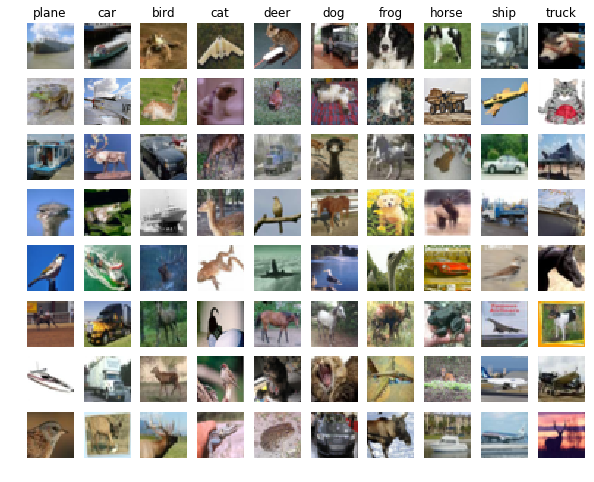

In [19]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Yes, colors and global shapes are the ones expected for the labels


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [20]:
print(X_train_feats.shape)

(49000, 155)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
results = {}
best_val = -1
best_stats = None

learning_rates = [1e-3,1e-2,1e-1,1]
#learning_rates = [1]
regularization_strengths = [0.5,1.0,1.5,2.0]
#regularization_strengths = [0.1]
hidden_sizes = [100,200,500]
#hidden_sizes = [500]
epochs = [500,1500,2000]
#epochs = [200]

input_size = 32 * 32 * 3
num_classes = 10

for h in range(len(hidden_sizes)):
    net = TwoLayerNet(input_dim, hidden_sizes[h], num_classes)
    for l in range(len(learning_rates)):
        for r in range(len(regularization_strengths)):
            for e in range(len(epochs)):
                print('hid %e lr %e reg %e ep %e' % (hidden_sizes[h], learning_rates[l],regularization_strengths[r],epochs[e]))
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val, 
                                  num_iters=epochs[e], batch_size=200,
                                  learning_rate = learning_rates[l], learning_rate_decay=0.95,
                                  reg=regularization_strengths[r],
                                  verbose=True)
                y_train_pred = net.predict(X_train_feats)
                y_val_pred = net.predict(X_val_feats)
                acc_train = np.mean(y_train == y_train_pred)
                acc_val = np.mean(y_val == y_val_pred)
                results[(hidden_sizes[h],learning_rates[l],regularization_strengths[r],epochs[e])] = (acc_train,acc_val)
                if(best_val<(np.mean(y_val == y_val_pred), )): 
                    best_val = acc_val
                    best_net = net
                    best_stats = stats

# Print out results.
for hid, lr, reg, ep in sorted(results):
    train_accuracy, val_accuracy = results[(hid, lr, reg, ep)]
    print('hid %e lr %e reg %e ep %e train accuracy: %f val accuracy: %f' % (
                hid, lr, reg, ep, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

hid 1.000000e+02 lr 1.000000e-03 reg 5.000000e-01 ep 5.000000e+02
iteration 0 / 500: loss 2.302667
iteration 100 / 500: loss 2.302642
iteration 200 / 500: loss 2.302616
iteration 300 / 500: loss 2.302682
iteration 400 / 500: loss 2.302633
[0.105, 0.075, 0.09] [0.098, 0.078, 0.079]
hid 1.000000e+02 lr 1.000000e-03 reg 5.000000e-01 ep 1.500000e+03
iteration 0 / 1500: loss 2.302656
iteration 100 / 1500: loss 2.302570
iteration 200 / 1500: loss 2.302619
iteration 300 / 1500: loss 2.302531
iteration 400 / 1500: loss 2.302609
iteration 500 / 1500: loss 2.302530
iteration 600 / 1500: loss 2.302642
iteration 700 / 1500: loss 2.302626
iteration 800 / 1500: loss 2.302599
iteration 900 / 1500: loss 2.302556
iteration 1000 / 1500: loss 2.302617
iteration 1100 / 1500: loss 2.302618
iteration 1200 / 1500: loss 2.302555
iteration 1300 / 1500: loss 2.302611
iteration 1400 / 1500: loss 2.302615
[0.1, 0.125, 0.105, 0.14, 0.07, 0.105, 0.105] [0.079, 0.078, 0.078, 0.078, 0.079, 0.079, 0.079]
hid 1.000000e

iteration 700 / 1500: loss 2.302372
iteration 800 / 1500: loss 2.303211
iteration 900 / 1500: loss 2.303026
iteration 1000 / 1500: loss 2.301526
iteration 1100 / 1500: loss 2.302810
iteration 1200 / 1500: loss 2.303137
iteration 1300 / 1500: loss 2.303399
iteration 1400 / 1500: loss 2.302577
[0.07, 0.11, 0.075, 0.07, 0.105, 0.1, 0.09] [0.078, 0.078, 0.102, 0.078, 0.078, 0.078, 0.078]
hid 1.000000e+02 lr 1.000000e-02 reg 5.000000e-01 ep 2.000000e+03
iteration 0 / 2000: loss 2.302892
iteration 100 / 2000: loss 2.302380
iteration 200 / 2000: loss 2.303014
iteration 300 / 2000: loss 2.302702
iteration 400 / 2000: loss 2.302630
iteration 500 / 2000: loss 2.302904
iteration 600 / 2000: loss 2.302377
iteration 700 / 2000: loss 2.302346
iteration 800 / 2000: loss 2.302688
iteration 900 / 2000: loss 2.302817
iteration 1000 / 2000: loss 2.302567
iteration 1100 / 2000: loss 2.302646
iteration 1200 / 2000: loss 2.303059
iteration 1300 / 2000: loss 2.302078
iteration 1400 / 2000: loss 2.302661
iter

iteration 500 / 2000: loss 2.301278
iteration 600 / 2000: loss 2.302186
iteration 700 / 2000: loss 2.301790
iteration 800 / 2000: loss 2.301697
iteration 900 / 2000: loss 2.301565
iteration 1000 / 2000: loss 2.301442
iteration 1100 / 2000: loss 2.302023
iteration 1200 / 2000: loss 2.302427
iteration 1300 / 2000: loss 2.301705
iteration 1400 / 2000: loss 2.302821
iteration 1500 / 2000: loss 2.302754
iteration 1600 / 2000: loss 2.301991
iteration 1700 / 2000: loss 2.303191
iteration 1800 / 2000: loss 2.302116
iteration 1900 / 2000: loss 2.301643
[0.09, 0.085, 0.1, 0.125, 0.085, 0.06, 0.085, 0.105, 0.105] [0.079, 0.098, 0.098, 0.087, 0.098, 0.112, 0.112, 0.102, 0.079]
hid 1.000000e+02 lr 1.000000e-01 reg 1.000000e+00 ep 5.000000e+02
iteration 0 / 500: loss 2.302668
iteration 100 / 500: loss 2.302957
iteration 200 / 500: loss 2.301424
iteration 300 / 500: loss 2.300025
iteration 400 / 500: loss 2.302924
[0.1, 0.105, 0.095] [0.113, 0.119, 0.079]
hid 1.000000e+02 lr 1.000000e-01 reg 1.000000

hid 1.000000e+02 lr 1.000000e+00 reg 1.000000e+00 ep 5.000000e+02
iteration 0 / 500: loss 2.300853
iteration 100 / 500: loss inf


cs231n/classifiers/neural_net.py:104: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(p[np.arange(N), y]))


iteration 200 / 500: loss inf
iteration 300 / 500: loss inf
iteration 400 / 500: loss inf
[0.135, 0.04, 0.05] [0.079, 0.052, 0.052]
hid 1.000000e+02 lr 1.000000e+00 reg 1.000000e+00 ep 1.500000e+03
iteration 0 / 1500: loss inf
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf


cs231n/classifiers/neural_net.py:100: RuntimeWarning: overflow encountered in subtract
  s = scores - np.max(scores, axis=1, keepdims=True) # max of every score
cs231n/classifiers/neural_net.py:100: RuntimeWarning: invalid value encountered in subtract
  s = scores - np.max(scores, axis=1, keepdims=True) # max of every score
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
cs231n/classifiers/neural_net.py:132: RuntimeWarning: invalid value encountered in less_equal
  dhidden[H1 <= 0] = 0


iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
[0.05, 0.12, 0.075, 0.06, 0.075, 0.12, 0.105] [0.052, 0.085, 0.087, 0.087, 0.087, 0.087, 0.087]
hid 1.000000e+02 lr 1.000000e+00 reg 1.000000e+00 ep 2.000000e+03
iteration 0 / 2000: loss nan
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: lo

iteration 1600 / 2000: loss 2.302519
iteration 1700 / 2000: loss 2.302553
iteration 1800 / 2000: loss 2.302557
iteration 1900 / 2000: loss 2.302546
[0.065, 0.08, 0.085, 0.095, 0.08, 0.1, 0.14, 0.115, 0.085] [0.079, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079]
hid 2.000000e+02 lr 1.000000e-03 reg 1.500000e+00 ep 5.000000e+02
iteration 0 / 500: loss 2.302539
iteration 100 / 500: loss 2.302666
iteration 200 / 500: loss 2.302647
iteration 300 / 500: loss 2.302636
iteration 400 / 500: loss 2.302609
[0.115, 0.095, 0.08] [0.079, 0.079, 0.079]
hid 2.000000e+02 lr 1.000000e-03 reg 1.500000e+00 ep 1.500000e+03
iteration 0 / 1500: loss 2.302584
iteration 100 / 1500: loss 2.302610
iteration 200 / 1500: loss 2.302624
iteration 300 / 1500: loss 2.302720
iteration 400 / 1500: loss 2.302581
iteration 500 / 1500: loss 2.302448
iteration 600 / 1500: loss 2.302440
iteration 700 / 1500: loss 2.302672
iteration 800 / 1500: loss 2.302484
iteration 900 / 1500: loss 2.302679
iteration 1000 / 1500: 

iteration 100 / 1500: loss 2.302758
iteration 200 / 1500: loss 2.303297
iteration 300 / 1500: loss 2.302379
iteration 400 / 1500: loss 2.303852
iteration 500 / 1500: loss 2.302564
iteration 600 / 1500: loss 2.302814
iteration 700 / 1500: loss 2.302447
iteration 800 / 1500: loss 2.302497
iteration 900 / 1500: loss 2.302917
iteration 1000 / 1500: loss 2.302901
iteration 1100 / 1500: loss 2.302105
iteration 1200 / 1500: loss 2.302190
iteration 1300 / 1500: loss 2.302745
iteration 1400 / 1500: loss 2.302430
[0.105, 0.09, 0.135, 0.105, 0.08, 0.09, 0.11] [0.079, 0.078, 0.078, 0.078, 0.107, 0.107, 0.107]
hid 2.000000e+02 lr 1.000000e-02 reg 1.500000e+00 ep 2.000000e+03
iteration 0 / 2000: loss 2.302518
iteration 100 / 2000: loss 2.302725
iteration 200 / 2000: loss 2.303307
iteration 300 / 2000: loss 2.302522
iteration 400 / 2000: loss 2.302746
iteration 500 / 2000: loss 2.302459
iteration 600 / 2000: loss 2.302158
iteration 700 / 2000: loss 2.302503
iteration 800 / 2000: loss 2.303105
iterati

hid 2.000000e+02 lr 1.000000e-01 reg 1.500000e+00 ep 2.000000e+03
iteration 0 / 2000: loss 2.301894
iteration 100 / 2000: loss 2.301172
iteration 200 / 2000: loss 2.300429
iteration 300 / 2000: loss 2.304995
iteration 400 / 2000: loss 2.304600
iteration 500 / 2000: loss 2.301826
iteration 600 / 2000: loss 2.303089
iteration 700 / 2000: loss 2.301925
iteration 800 / 2000: loss 2.303939
iteration 900 / 2000: loss 2.302896
iteration 1000 / 2000: loss 2.302513
iteration 1100 / 2000: loss 2.302931
iteration 1200 / 2000: loss 2.302064
iteration 1300 / 2000: loss 2.301736
iteration 1400 / 2000: loss 2.302959
iteration 1500 / 2000: loss 2.302643
iteration 1600 / 2000: loss 2.302846
iteration 1700 / 2000: loss 2.300231
iteration 1800 / 2000: loss 2.302297
iteration 1900 / 2000: loss 2.303346
[0.09, 0.1, 0.07, 0.125, 0.125, 0.145, 0.085, 0.09, 0.11] [0.079, 0.098, 0.098, 0.112, 0.113, 0.105, 0.113, 0.078, 0.119]
hid 2.000000e+02 lr 1.000000e-01 reg 2.000000e+00 ep 5.000000e+02
iteration 0 / 500:

cs231n/classifiers/neural_net.py:107: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * (np.sum(W1*W1)+np.sum(W2*W2))


iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
[0.08, 0.08, 0.095, 0.075, 0.085, 0.115, 0.115] [0.075, 0.065, 0.087, 0.087, 0.087, 0.087, 0.087]
hid 2.000000e+02 lr 1.000000e+00 reg 1.000000e+00 ep 2.000000e+03
iteration 0 / 2000: loss nan
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: 

iteration 1600 / 2000: loss 2.302490
iteration 1700 / 2000: loss 2.302547
iteration 1800 / 2000: loss 2.302563
iteration 1900 / 2000: loss 2.302741
[0.1, 0.15, 0.12, 0.14, 0.14, 0.095, 0.145, 0.1, 0.13] [0.078, 0.078, 0.078, 0.078, 0.078, 0.078, 0.078, 0.078, 0.078]
hid 5.000000e+02 lr 1.000000e-03 reg 1.500000e+00 ep 5.000000e+02
iteration 0 / 500: loss 2.302732
iteration 100 / 500: loss 2.302587
iteration 200 / 500: loss 2.302472
iteration 300 / 500: loss 2.302655
iteration 400 / 500: loss 2.302764
[0.07, 0.06, 0.1] [0.078, 0.078, 0.078]
hid 5.000000e+02 lr 1.000000e-03 reg 1.500000e+00 ep 1.500000e+03
iteration 0 / 1500: loss 2.302444
iteration 100 / 1500: loss 2.302346
iteration 200 / 1500: loss 2.302369
iteration 300 / 1500: loss 2.302634
iteration 400 / 1500: loss 2.302495
iteration 500 / 1500: loss 2.302452
iteration 600 / 1500: loss 2.302500
iteration 700 / 1500: loss 2.302526
iteration 800 / 1500: loss 2.302434
iteration 900 / 1500: loss 2.302672
iteration 1000 / 1500: loss 2.

iteration 100 / 1500: loss 2.302451
iteration 200 / 1500: loss 2.302623
iteration 300 / 1500: loss 2.302607
iteration 400 / 1500: loss 2.302982
iteration 500 / 1500: loss 2.302129
iteration 600 / 1500: loss 2.302485
iteration 700 / 1500: loss 2.303149
iteration 800 / 1500: loss 2.303050
iteration 900 / 1500: loss 2.303086
iteration 1000 / 1500: loss 2.302684
iteration 1100 / 1500: loss 2.303160
iteration 1200 / 1500: loss 2.303176
iteration 1300 / 1500: loss 2.302245
iteration 1400 / 1500: loss 2.302826
[0.085, 0.085, 0.1, 0.1, 0.135, 0.105, 0.075] [0.087, 0.087, 0.079, 0.079, 0.079, 0.119, 0.087]
hid 5.000000e+02 lr 1.000000e-02 reg 1.500000e+00 ep 2.000000e+03
iteration 0 / 2000: loss 2.302868
iteration 100 / 2000: loss 2.302838
iteration 200 / 2000: loss 2.303280
iteration 300 / 2000: loss 2.302659
iteration 400 / 2000: loss 2.302584
iteration 500 / 2000: loss 2.302507
iteration 600 / 2000: loss 2.302628
iteration 700 / 2000: loss 2.302438
iteration 800 / 2000: loss 2.302308
iterati

hid 5.000000e+02 lr 1.000000e-01 reg 1.500000e+00 ep 2.000000e+03
iteration 0 / 2000: loss 2.303461
iteration 100 / 2000: loss 2.302223
iteration 200 / 2000: loss 2.303420
iteration 300 / 2000: loss 2.304736
iteration 400 / 2000: loss 2.302015
iteration 500 / 2000: loss 2.302841
iteration 600 / 2000: loss 2.302769
iteration 700 / 2000: loss 2.300843
iteration 800 / 2000: loss 2.301865
iteration 900 / 2000: loss 2.302525
iteration 1000 / 2000: loss 2.302276
iteration 1100 / 2000: loss 2.301830
iteration 1200 / 2000: loss 2.302319
iteration 1300 / 2000: loss 2.302554
iteration 1400 / 2000: loss 2.302221
iteration 1500 / 2000: loss 2.300473
iteration 1600 / 2000: loss 2.303212
iteration 1700 / 2000: loss 2.304161
iteration 1800 / 2000: loss 2.301813
iteration 1900 / 2000: loss 2.301862
[0.105, 0.095, 0.115, 0.12, 0.085, 0.1, 0.08, 0.085, 0.11] [0.113, 0.087, 0.113, 0.112, 0.079, 0.113, 0.102, 0.087, 0.079]
hid 5.000000e+02 lr 1.000000e-01 reg 2.000000e+00 ep 5.000000e+02
iteration 0 / 500

In [28]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.1


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!